# Hedge Your Own Funds: Running Monte Carlo Simulations on EC2 Spot
Welcome to our workshop we will use this Jupyter notebook to dive deeper into the basic elements of an Algorithmic Trading platform. We will cover the following topics:

1. Setting up our Python Environment
2. Importing and Manipulating Stock Data
3. Basic Financial Analysis
4. Backtest a Trading Strategy
5. Use Past Performance to Predict the Future
6. Evaluate Performance with a Monte Carlo Simulation

### <span style="color:red">Note: The code examples provided are for educational purposes only. They should NOT be used for live trading.</span>

Trading terms and defintions were sourced from [investopedia.com](http://www.investopedia.com)



## Setting up our Python Environment

We will start out by importing the libraries that we will be using throughout the workshop.

- [pandas](https://pandas.pydata.org) - Flexible and powerful data analysis / manipulation library for Python
- [numpy](http://www.numpy.org) - A library for the Python programming language, adding support for large, multi-dimensional arrays and matrices.
- [datetime](https://docs.python.org/3/library/datetime.html) - We will be working with Time Series Data 
- [matplotlib](https://matplotlib.org/) - A 2D python plotting library that can generate plots, histograms, power spectra, bar charts, errorcharts, scatterplots, etc., with just a few lines of code.

## Importing and Manipulating Stock Data

In [7]:
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import datetime
import matplotlib.pyplot as plt
from math import sqrt, fabs
from scipy.stats import norm
%matplotlib inline

Enter the ticker symbol for the stock you'd like to evaluate or continue with the default.

In [8]:
STOCK = 'AMZN'
print(STOCK)

AMZN


We will use the pandas-data-reader to create a data frame using the Yahoo Finance API. We can specify start and end dates for our data import. The resulting data frame is a securities chart that clearly shows the opening, high, low and closing prices (OHLC) for a security.

In [12]:
import fix_yahoo_finance as yf
yf.pdr_override()
stock_df = pdr.get_data_yahoo(STOCK, 
                          start=datetime.datetime(2016, 1, 1), 
                          end=datetime.datetime(2016, 12, 31))

[*********************100%***********************]  1 of 1 downloaded


The columns attribute will show you the Data Labels.

In [13]:
stock_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

You can use built-in head() and tail() methods to explore the beginning or end of the data frame respectively. These allow you to get a feel for the data.

In [14]:
#print the most recent days OHLC Values
stock_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-12-23,764.549988,766.500000,757.989990,760.590027,760.590027,1976900
2016-12-27,763.400024,774.650024,761.200012,771.400024,771.400024,2638700
2016-12-28,776.250000,780.000000,770.500000,772.130005,772.130005,3301000
2016-12-29,772.400024,773.400024,760.849976,765.150024,765.150024,3153500
2016-12-30,766.469971,767.400024,748.280029,749.869995,749.869995,4139400


In [15]:
#print the earliest OHLC Values
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,656.289978,657.719971,627.510010,636.989990,636.989990,9314500
2016-01-05,646.859985,646.909973,627.650024,633.789978,633.789978,5822600
2016-01-06,622.000000,639.789978,620.309998,632.650024,632.650024,5329200
2016-01-07,621.799988,630.000000,605.210022,607.940002,607.940002,7074900
2016-01-08,619.659973,624.140015,606.000000,607.049988,607.049988,5512900


You can specify a column label to return a data frame containing only those values.

In [ ]:
stock_df['Open']


We will use matplotlib to visualize various aspects of our data. If we want to plot the closing price by day, we would do the following:

In [ ]:
stock_df['Close'].plot()
plt.show()

You can use the describe() method to display summary statistics about the data frame.

For numeric data, the result’s index will include count, mean, std, min, max as well as lower, 50 and upper percentiles. By default the lower percentile is 25 and the upper percentile is 75. The 50 percentile is the same as the median.

For object data (e.g. strings or timestamps), the result’s index will include count, unique, top, and freq. The top is the most common value. The freq is the most common value’s frequency. Timestamps also include the first and last items.

A typical year contains [252 trading days](https://en.wikipedia.org/wiki/Trading_day). You will see this window used throughout the exercises.

In [4]:
stock_df.describe()

NameError: name 'stock_df' is not defined

## Basic Financial Analysis
Typically, data will need to be cleaned or transformed before it is usable. Let's take a look at a simple example of calculating our stock's daily [percent change](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.pct_change.html), which is the perctage of loss or gain experienced that day. We will use the fillna method to replace any blank values from our import with 0. We will also use the columns attribute to change the Column label.

### Calculate Daily and Annualized Returns

In [10]:
# Save daily returns as a new column
stock_df['Daily Return'] = stock_df[['Adj Close']].pct_change()

# Replace NA values with 0
stock_df['Daily Return'].fillna(0, inplace=True)

stock_df['Daily Return'].tail()

Date
2016-12-23   -0.007503
2016-12-27    0.014213
2016-12-28    0.000946
2016-12-29   -0.009040
2016-12-30   -0.019970
Name: Daily Return, dtype: float64

Now that we've calculated daily returns lets take a look at annualized returns.

In [11]:
# Calculate the average daily return
mean_return = stock_df['Daily Return'].mean()

# Annualize the returns
annualised_return = round(mean_return * 252,2)

# Annualized Mean Return. How much are we making or losing on average?
print(annualised_return)

0.21


### Calculate Risk

While returns are the goal of any trading strategy, risk must be evaluated as well. [Standard Deviation](https://www.investopedia.com/terms/s/standarddeviation.asp) is the most commonly used risk measure. We will use the built-in [std() method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.std.html). 

In [12]:
# Calculate the Standard Deviation
std_return = stock_df['Daily Return'].std()

# Annualize the standard deviation. This is also known as Volatility
volatility = round(np.sqrt(252) * std_return,2)

#The higher the result, the more volatile the stock!
print(volatility)

0.29


### Calculate the Sharpe Ratio

The [Sharpe Ratio](https://www.investopedia.com/terms/s/sharperatio.asp) is a measure of risk/return. This ratio is best applicable to investments with a [normal distribution](https://www.investopedia.com/terms/n/normaldistribution.asp) of returns. We will use the built-in hist() method to visualize Daily Returns as a histogram.

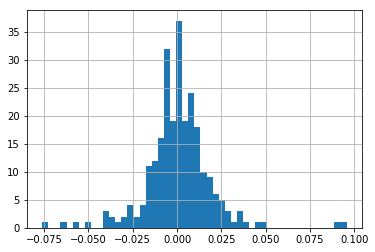

In [13]:
stock_df['Daily Return'].hist(bins=50)

A [Sharpe Ratio](https://www.investopedia.com/terms/s/sharperatio.asp) is the average return earned in excess of risk-free rate per unit of volatility. In other words, we will compare our stock against a benchmark considered risk-free. Let's use a standard return of 5% over the trading period (252 days)

In [14]:
stock_df['Excess Returns'] = stock_df['Daily Return'] - 0.05/252
annualised_sharpe = np.sqrt(252) * stock_df['Excess Returns'].mean() / stock_df['Excess Returns'].std()

#The higher the result, the better!
print(annualised_sharpe) 


0.533189979618


### Calculate Maximum Drawdown

[Maximum Drawdown (MDD)](https://www.investopedia.com/terms/m/maximum-drawdown-mdd.asp) is the maximum loss from a peak to a trough before a new peak is attained.
This is used as a measure of downside risk over a period of time.

MDD = (Trough Value – Peak Value) ÷ Peak Value

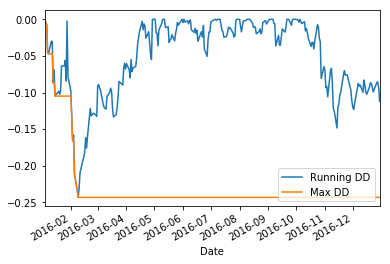

In [15]:
# Calculate the max drawdown in the past window days for each day in the series.
rolling_max = stock_df['Adj Close'].rolling(min_periods=1,center=False,window=252).max()
daily_drawdown = stock_df['Adj Close'] / rolling_max - 1.0

# Next we calculate the minimum (negative) daily drawdown in that window.
max_daily_drawdown = daily_drawdown.rolling(min_periods=1,center=False,window=252).min()

# Plot the results
daily_drawdown.plot(label='Running DD')
max_daily_drawdown.plot(label='Max DD')
plt.legend(loc="lower right")
plt.show()

## Backtest a Trading Strategy

In this step, we will test a strategy against historical data to see how it would have performed. This process is know as backtesting. We will use a common strategy known as [the Moving Average Crossover](https://en.wikipedia.org/wiki/Moving_average_crossover)

In this strategy, two Simple Moving Averages (SMA) of a time series with differing lookback periods are calculated. If the short moving average exceeds the long moving average, then you go long. If the long moving average exceeds the short moving average then you exit.

We will calculate short (40 days) moving avg and long (100 days) moving avg. Moving average smoothes out short-term fluctuations and highlights longer-term trends in data. If short moving average is crossing the long moving average then generate a trading order. 

We will use the pandas.DataFrame.rolling to calculate the moving average. More details about rolling method avaliable here: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html

In [16]:
# Initialize the short and long windows
short_window = 40
long_window = 100

# Initialize the 'signals' DataFrame with a single 'signal' column, use the same index (Date) from stock_df 
signals = pd.DataFrame(index=stock_df.index)
# initialize by setting the value for all rows in this column to 0.0.
signals['signal'] = 0.0
# Create short simple moving average over the short window
signals['short_mavg'] = stock_df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = stock_df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create a signal when the short moving average crosses the long moving average, 
# but only for the period greater than the shortest moving average window. 
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

print(signals.head())

# print buy stock dates 
signals[signals.positions > 0]




            signal  short_mavg   long_mavg  positions
Date                                                 
2016-01-04     0.0  636.989990  636.989990        NaN
2016-01-05     0.0  635.389984  635.389984        0.0
2016-01-06     0.0  634.476664  634.476664        0.0
2016-01-07     0.0  627.842499  627.842499        0.0
2016-01-08     0.0  623.683996  623.683996        0.0


,signal,short_mavg,long_mavg,positions
Date,,,,
2016-04-13,1.0,572.386749,571.495142,1.0


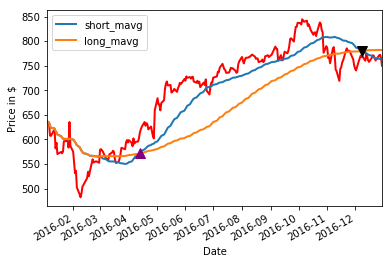

In [17]:
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
stock_df['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='purple')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='black')
         
# Show the plot

plt.rcParams["figure.figsize"] = (22,35)




In [18]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions[STOCK] = 100*signals['signal']
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(stock_df['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(stock_df['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(stock_df['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio.head())

# Print the last lines of `portfolio`
print(portfolio.tail())

portfolio.describe()

portfolio

            AMZN  holdings      cash     total  returns
Date                                                   
2016-01-04   0.0       0.0       NaN       NaN      NaN
2016-01-05   0.0       0.0  100000.0  100000.0      NaN
2016-01-06   0.0       0.0  100000.0  100000.0      0.0
2016-01-07   0.0       0.0  100000.0  100000.0      0.0
2016-01-08   0.0       0.0  100000.0  100000.0      0.0
            AMZN  holdings        cash       total  returns
Date                                                       
2016-12-23   0.0       0.0  115251.001  115251.001      0.0
2016-12-27   0.0       0.0  115251.001  115251.001      0.0
2016-12-28   0.0       0.0  115251.001  115251.001      0.0
2016-12-29   0.0       0.0  115251.001  115251.001      0.0
2016-12-30   0.0       0.0  115251.001  115251.001      0.0


,AMZN,holdings,cash,total,returns
Date,,,,,
2016-01-04,0.0000,0.0000,NaN,NaN,NaN
2016-01-05,0.0000,0.0000,100000.0000,100000.0000,NaN
2016-01-06,0.0000,0.0000,100000.0000,100000.0000,0.000000
2016-01-07,0.0000,0.0000,100000.0000,100000.0000,0.000000
2016-01-08,0.0000,0.0000,100000.0000,100000.0000,0.000000
2016-01-11,0.0000,0.0000,100000.0000,100000.0000,0.000000
2016-01-12,0.0000,0.0000,100000.0000,100000.0000,0.000000
2016-01-13,0.0000,0.0000,100000.0000,100000.0000,0.000000
2016-01-14,0.0000,0.0000,100000.0000,100000.0000,0.000000


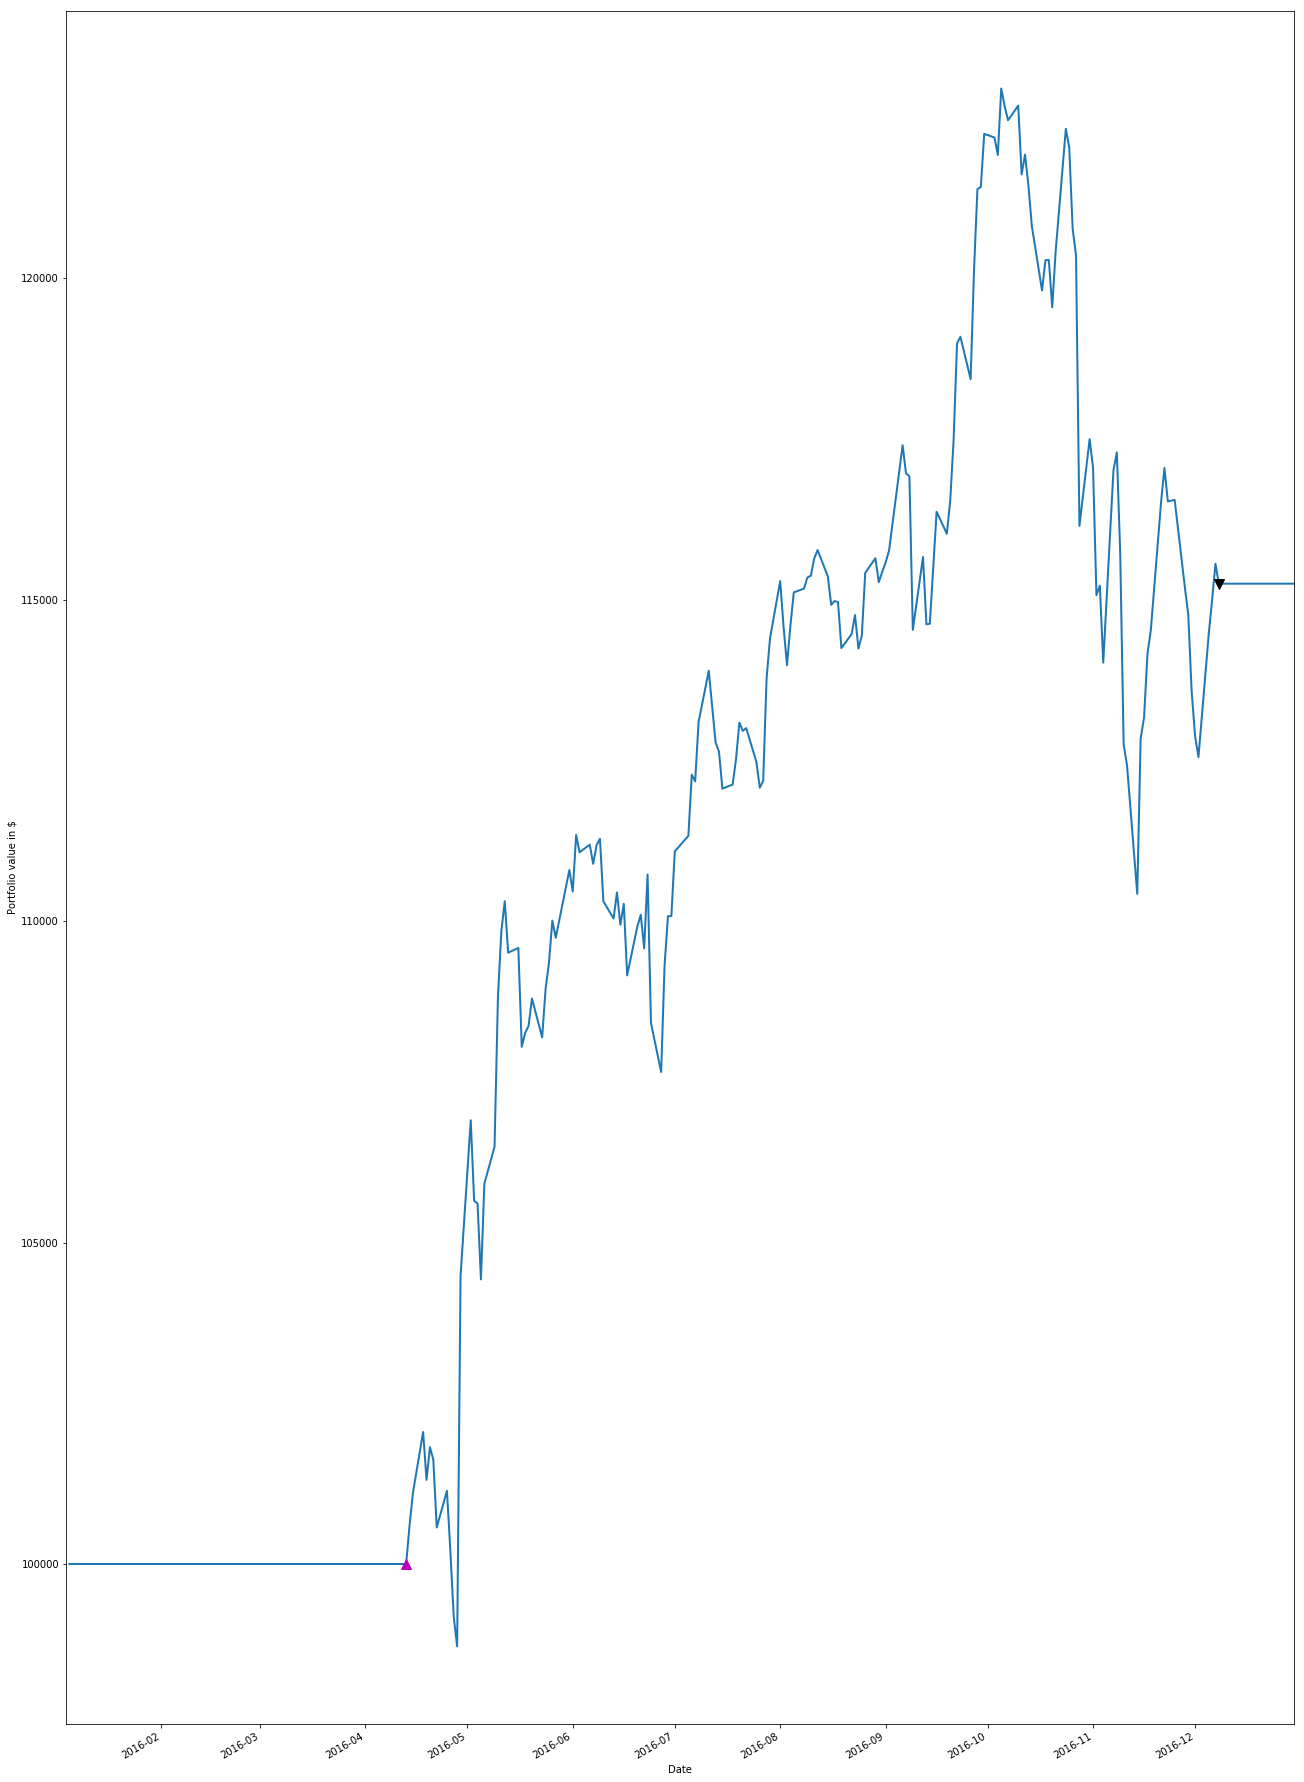

In [20]:
# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

The graph above shows the performance of $100,000 using the strategy mentioned above.

## Use Past Performance to Predict the Future

To set up our simulation, we need to estimate the expected level of return (mu) and volatility (vol) of the stock in question. This data can be estimated from historic prices, with the simplest methods just assuming past mean return and volatility levels will continue into the future. One could also adjust historic data to account for investor views or market regime changes etc, however to keep things simple and concentrate on the code we will just set simple return and volatility levels based on past price data.

In [19]:
#calculate the compound annual growth rate (CAGR) which 
#will give us our mean return input (mu) 
days = (stock_df.index[-1] - stock_df.index[0]).days
cagr = ((((stock_df['Adj Close'][-1]) / stock_df['Adj Close'][1])) ** (365.0/days)) - 1
print ('CAGR =',str(round(cagr,4)*100)+"%")
mu = cagr
 
#create a series of percentage returns and calculate 
#the annual volatility of returns. Generally, the higher the volatility, 
#the riskier the investment in that stock, which results in investing in one over another.
stock_df['Returns'] = stock_df['Adj Close'].pct_change()
vol = stock_df['Returns'].std()*sqrt(252)
print ("Annual Volatility =",str(round(vol,4)*100)+"%")
 

CAGR = 18.54%
Annual Volatility = 29.18%


Now we know our mean return input (mu) which is the calculated CAGR and annual volatility of returns – the code to actually run the Monte Carlo simulation is as follows:

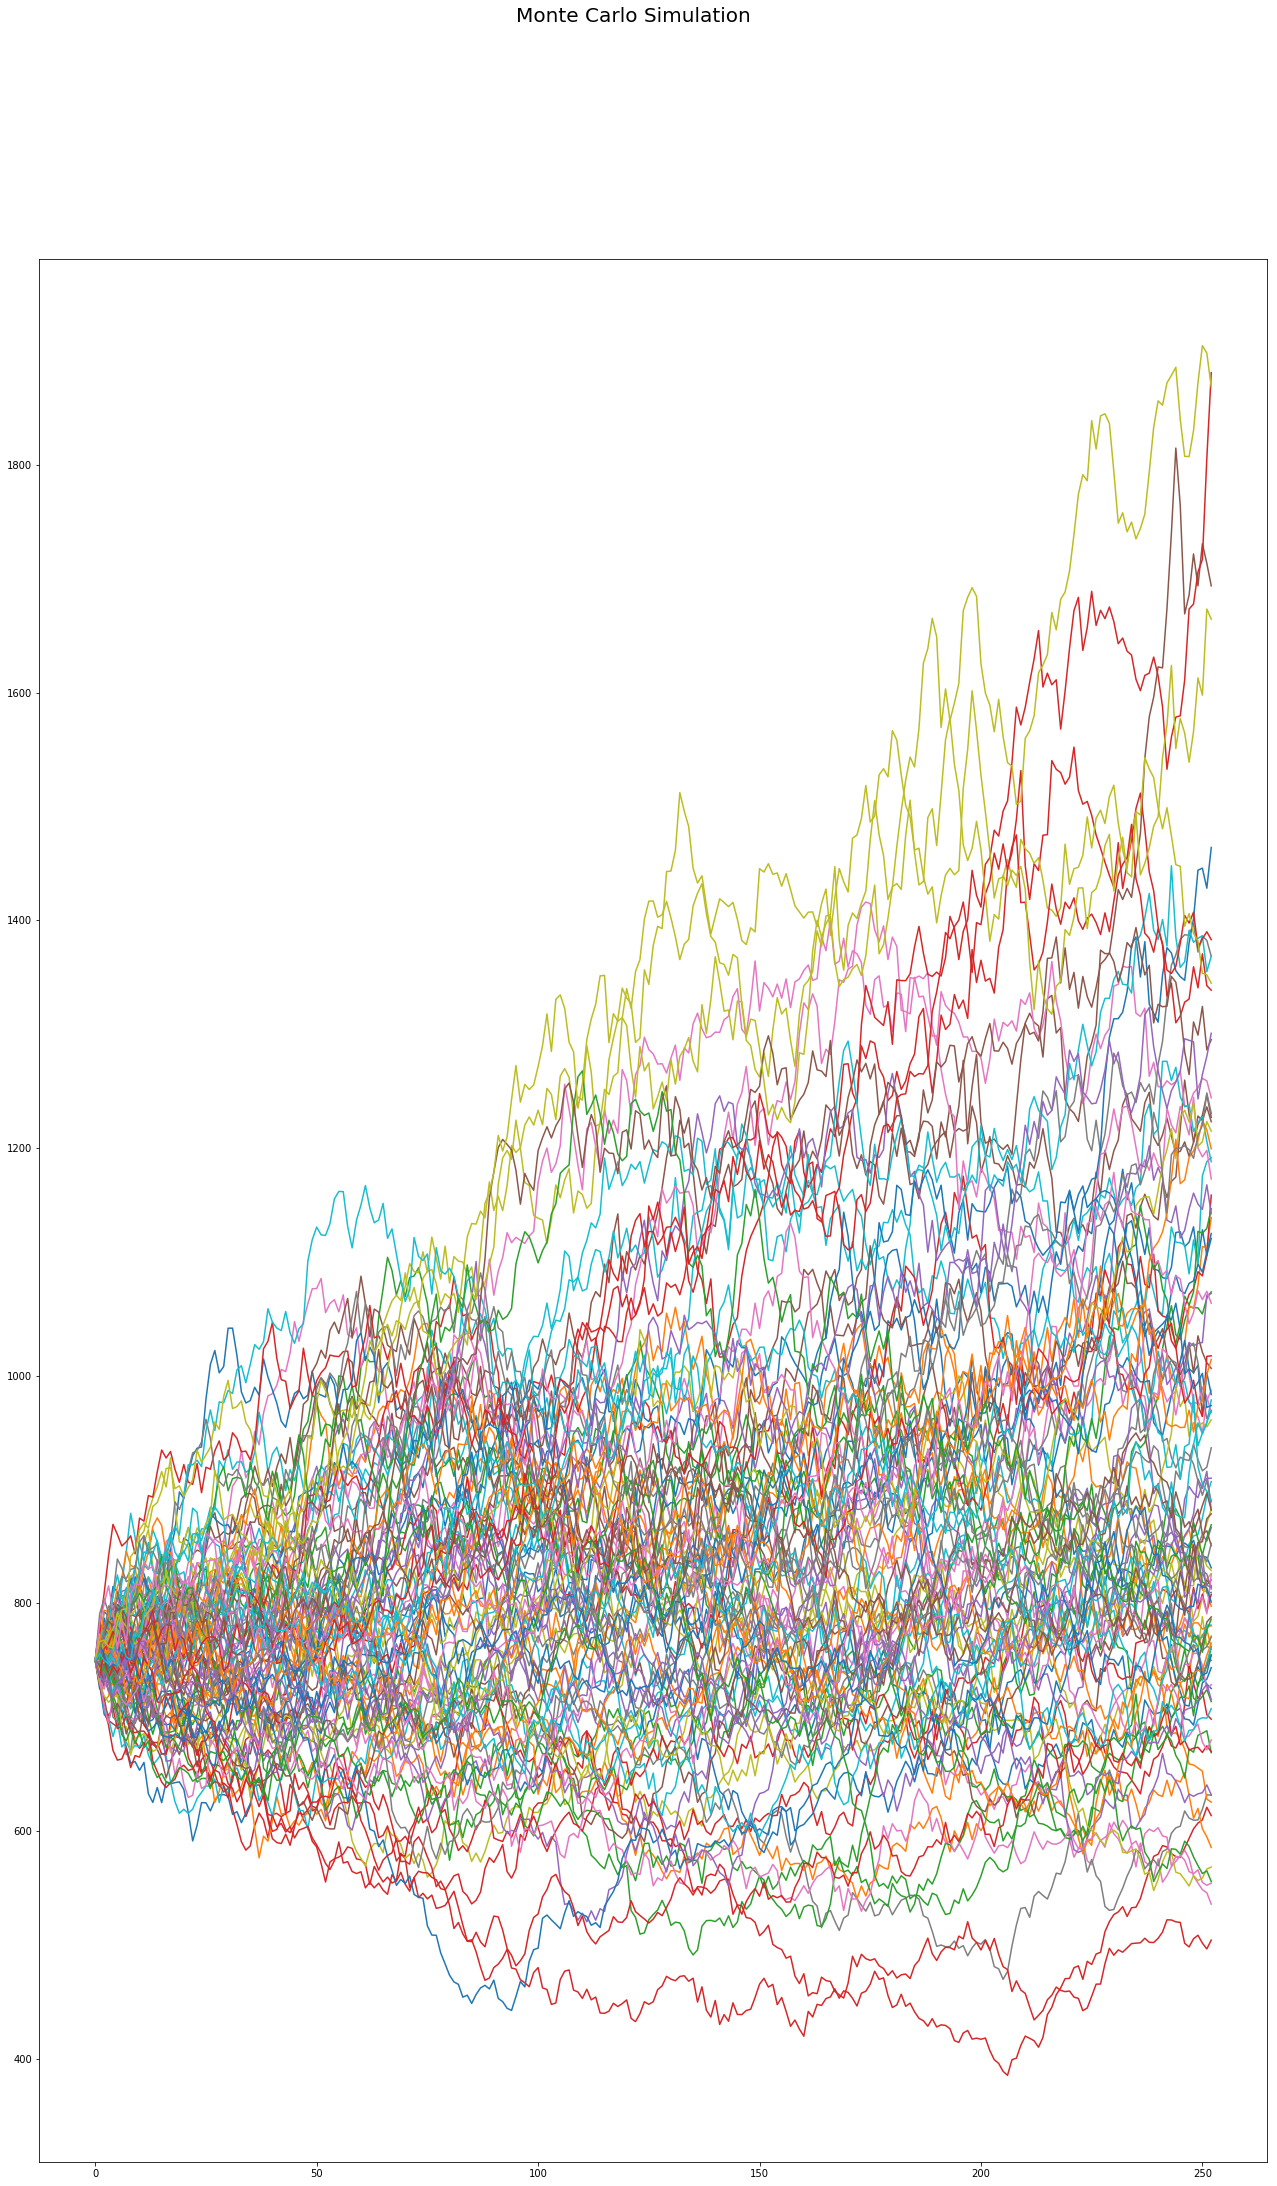

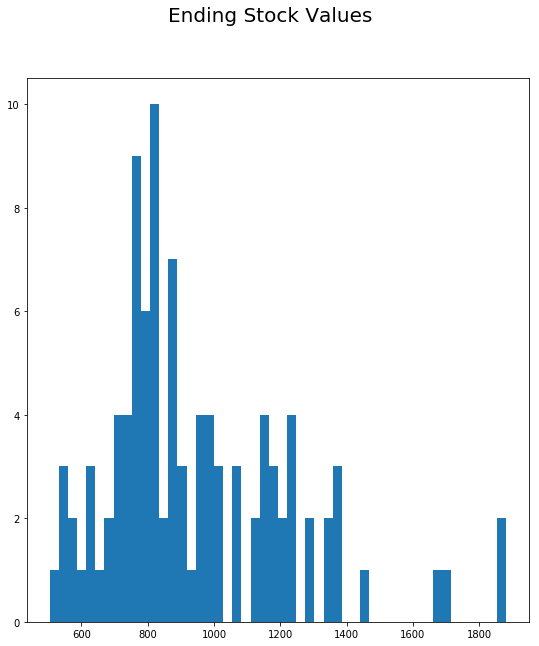

In [168]:
 #set up empty list to hold our ending values for each simulated price series
result = []
 
#Define Variables
start_price = stock_df['Adj Close'][-1] #starting stock price (i.e. last available real stock price)
trading_days = 252 #Number of trading days

 
#choose number of runs to simulate - I have chosen 1,00
for i in range(100):
    #create list of daily returns using random normal distribution
    daily_returns=np.random.normal(mu/trading_days,vol/sqrt(trading_days),trading_days)+1
 
    #set starting price and create price series generated by above random daily returns
    price_list = [start_price]
 
    for x in daily_returns:
        price_list.append(price_list[-1]*x)
 
    #plot data from each individual run which we will plot at the end
    plt.plot(price_list)
 
    #append the ending value of each simulated run to the empty list we created at the beginning
    result.append(price_list[-1])

plt.rcParams["figure.figsize"] = (9,10) 
plt.suptitle('Monte Carlo Simulation', fontsize=20)
#show the plot of multiple price series created above
plt.show()
 
#create histogram of ending stock values for our mutliple simulations
plt.suptitle('Ending Stock Values', fontsize=20)
plt.hist(result,bins=50)

plt.show()

## Evaluate Performance with a Monte Carlo Simulation

The problem that arises with a backtest is that its limited to what has already happened. Many strategies that perform well in backtests can perform poorly in future trades. A Monte Carlo simulation can introduce randomness to the stock movement to predict future performance under the assumption that future trades will perform more or less in the same range as previous trades but in a random order. We will run multiple simulations and look for trends that emerge.

In this section we will use the strategy we used above with Monte Carlo simulation results. We will also include all the code we need in order to run the code on Spot instances.

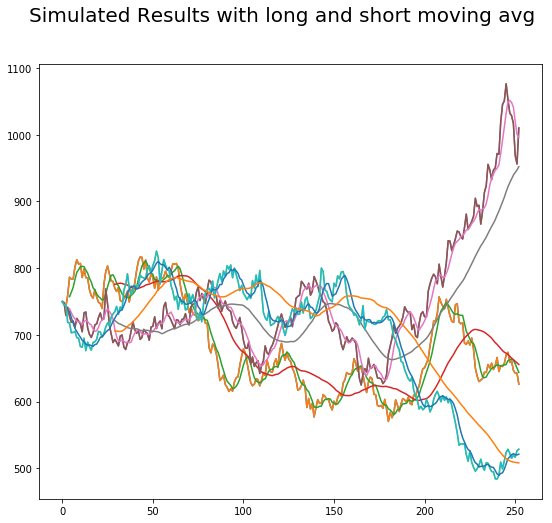

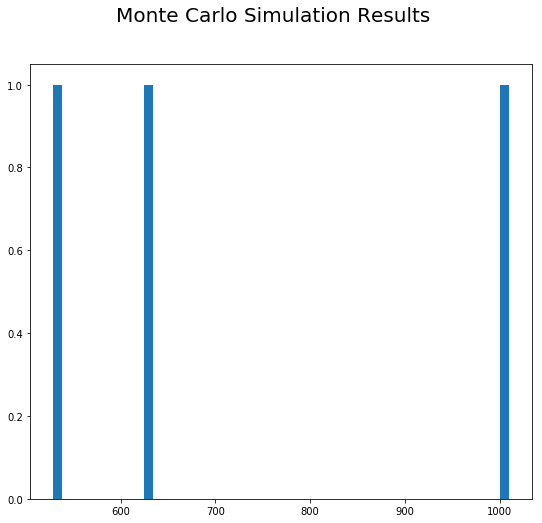

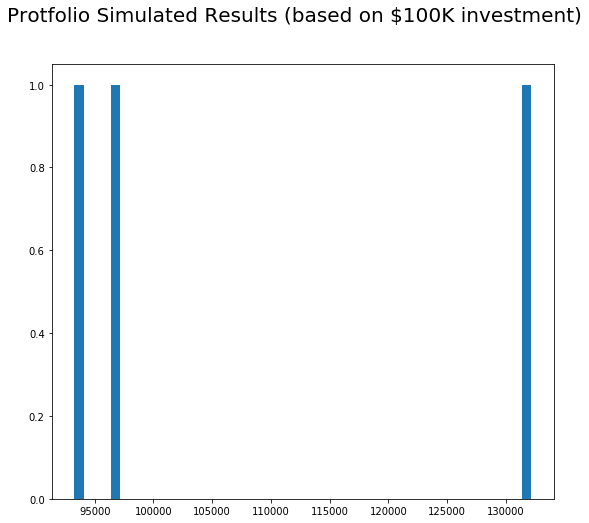

In [173]:
# Initialize the short and long windows
short_window = 5
long_window = 30

# Number of simulations - we will use a small number here so we could visualize the results.
sim_num = 3

# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

#set up empty list to hold our ending values for each simulated price series
sim_result = []

# Set up empty list to hold protfolio value for each simulated price serries, this is the value of position['total']
portfolio_total = []
 
#Define Variables
start_price = stock_df['Adj Close'][-1] #starting stock price (i.e. last available real stock price)
trading_days = 252 # Number of trading days



#calculate the compound annual growth rate (CAGR) which 
#will give us our mean return input (mu) 
days = (stock_df.index[-1] - stock_df.index[0]).days
cagr = ((((stock_df['Adj Close'][-1]) / stock_df['Adj Close'][1])) ** (365.0/days)) - 1
mu = cagr
 
#create a series of percentage returns and calculate 
#the annual volatility of returns. Generally, the higher the volatility, 
#the riskier the investment in that stock, which results in investing in one over another.
stock_df['Returns'] = stock_df['Adj Close'].pct_change()
vol = stock_df['Returns'].std()*sqrt(trading_days)


# Initialize the `signals` DataFrame 
signals = pd.DataFrame()

# initialize by setting the value for all rows in this column to 0.0.
signals['signal'] = 0.0
signals['short_mavg'] = 0.0


#choose number of runs to simulate - I have chosen 1,000
for i in range(sim_num):
    #create list of daily returns using random normal distribution
    daily_returns=np.random.normal(mu/trading_days,vol/sqrt(trading_days),trading_days)+1
 
    #set starting price and create price series generated by above random daily returns
    price_list = [start_price]
 
    for x in daily_returns:
        price_list.append(price_list[-1]*x)
 
    #plot data from each individual run which we will plot at the end
    plt.plot(price_list)
    
    #Convert list to Pandas DataFrame
    price_list_df = pd.DataFrame(price_list)
   
    #append the ending value of each simulated run to the empty list we created at the beginning
    sim_result.append(price_list[-1])
    
    # Create short simple moving average over the short & long window
    signals['short_mavg']  = price_list_df[0].rolling(short_window).mean()
    signals['long_mavg']  = price_list_df[0].rolling(long_window).mean()
 
    # Create a signal when the short moving average crosses the long moving average, 
    # but only for the period greater than the shortest moving average window. 
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    
    #plot data from each individual run which we will plot at the end
    plt.plot(price_list)
    plt.plot(signals['short_mavg'])
    plt.plot(signals['long_mavg'])
    
    # Buy 100 shares
    positions[STOCK] = 100*signals['signal']
  
    # Initialize the portfolio with value owned   
    portfolio = positions.multiply(price_list_df[0], axis=0)

    # Store the difference in shares owned 
    pos_diff = positions.diff()

    # Add `holdings` to portfolio
    portfolio['holdings'] = (positions.multiply(price_list_df[0], axis=0)).sum(axis=1)

    # Add `cash` to portfolio
    portfolio['cash'] = initial_capital - (pos_diff.multiply(price_list_df[0], axis=0)).sum(axis=1).cumsum()   

    # Add `total` to portfolio
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    
    #append the ending value of each simulated run to the empty list we created at the beginning
    portfolio_total.append(portfolio['total'].iloc[-1])

         
# Show the plot
plt.rcParams["figure.figsize"] = (15,18)
plt.suptitle('Simulated Results with long and short moving avg', fontsize=20)
plt.show()
    
#create histogram of ending stock values for our mutliple simulations
plt.rcParams["figure.figsize"] = (9,8)    
plt.suptitle('Monte Carlo Simulation Results', fontsize=20)
plt.hist(sim_result,bins=50)
plt.show()

#create histogram of ending protfolio values for our mutliple simulations, compare this value to "initial_capital"
# Clean portfolio_total from NaN
portfolio_total = [x for x in portfolio_total if x != 'nan']
plt.hist(portfolio_total,bins=50)
plt.suptitle('Protfolio Simulated Results (based on $100K investment)', fontsize=20)
plt.show()


You can evaluate the results on the next step, for example try to look at price_list, signals, portfolio_total and positions. You can also change sim_num to generate more simulations, in the next step we will increase the number of simulatitons and remove the line graphs. 

In [174]:
portfolio_total
#positions
#signals


[96411.330825581375, 132156.17548497522, 93277.667860155285]

This is the final version of the code, we will remove the line graph and write the end results of the simulation and  portfolio results into sim_result and portfolio_total list respectfuly. 

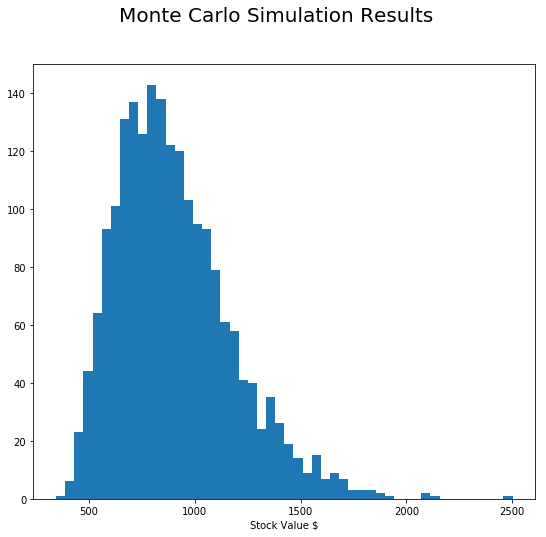

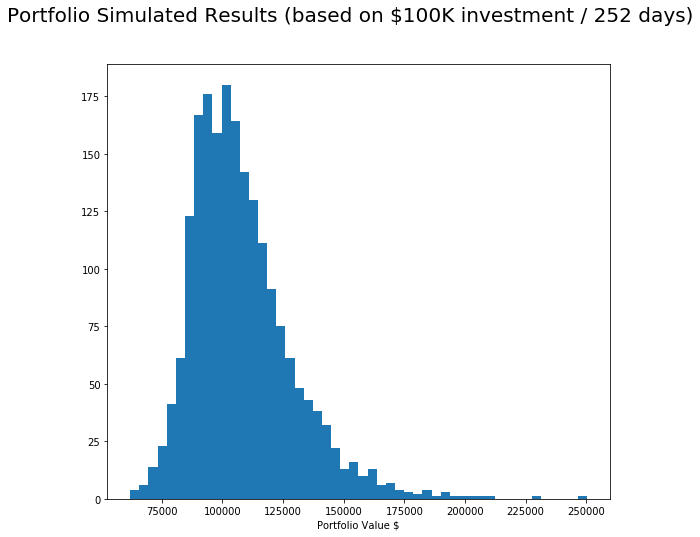

In [175]:
# Initialize the short and long windows
short_window = 5
long_window = 30

# Number of simulations
sim_num = 2000

# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

#set up empty list to hold our ending values for each simulated price series
sim_result = []

# Set up empty list to hold protfolio value for each simulated price serries, this is the value of position['total']
portfolio_total = []
 
#Define Variables
start_price = stock_df['Adj Close'][-1] #starting stock price (i.e. last available real stock price)
trading_days = 252 # Number of trading days


# Initialize the `signals` DataFrame 
signals = pd.DataFrame()

# initialize by setting the value for all rows in this column to 0.0.
signals['signal'] = 0.0
signals['short_mavg'] = 0.0

#calculate the compound annual growth rate (CAGR) which 
#will give us our mean return input (mu) 
days = (stock_df.index[-1] - stock_df.index[0]).days
cagr = ((((stock_df['Adj Close'][-1]) / stock_df['Adj Close'][1])) ** (365.0/days)) - 1
mu = cagr
 
#create a series of percentage returns and calculate 
#the annual volatility of returns. Generally, the higher the volatility, 
#the riskier the investment in that stock, which results in investing in one over another.
stock_df['Returns'] = stock_df['Adj Close'].pct_change()
vol = stock_df['Returns'].std()*sqrt(trading_days)



#choose number of runs to simulate 
for i in range(sim_num):
    #create list of daily returns using random normal distribution
    daily_returns=np.random.normal(mu/trading_days,vol/sqrt(trading_days),trading_days)+1
 
    #set starting price and create price series generated by above random daily returns
    price_list = [start_price]
 
    for x in daily_returns:
        price_list.append(price_list[-1]*x)
 
    #Convert list to Pandas DataFrame
    price_list_df = pd.DataFrame(price_list)
   
    #append the ending value of each simulated run to the empty list we created at the beginning
    sim_result.append(price_list[-1])
    
    # Create short simple moving average over the short & long window
    signals['short_mavg']  = price_list_df[0].rolling(short_window).mean()
    signals['long_mavg']  = price_list_df[0].rolling(long_window).mean()
 
    # Create a signal when the short moving average crosses the long moving average, 
    # but only for the period greater than the shortest moving average window. 
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    
    # Buy 100 shares
    positions[STOCK] = 100*signals['signal']
  
    # Initialize the portfolio with value owned   
    portfolio = positions.multiply(price_list_df[0], axis=0)

    # Store the difference in shares owned 
    pos_diff = positions.diff()

    # Add `holdings` to portfolio
    portfolio['holdings'] = (positions.multiply(price_list_df[0], axis=0)).sum(axis=1)

    # Add `cash` to portfolio
    portfolio['cash'] = initial_capital - (pos_diff.multiply(price_list_df[0], axis=0)).sum(axis=1).cumsum()   

    # Add `total` to portfolio
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    
    #append the ending value of each simulated run to the empty list we created at the beginning
    portfolio_total.append(portfolio['total'].iloc[-1])

    
#create histogram of ending stock values for our mutliple simulations
plt.rcParams["figure.figsize"] = (9,8)    
plt.hist(sim_result,bins=50)
plt.suptitle('Monte Carlo Simulation Results', fontsize=20)
plt.xlabel('Stock Value $')
plt.show()

#create histogram of ending protfolio values for our mutliple simulations, compare this value to "initial_capital"
plt.hist(portfolio_total,bins=50)
plt.suptitle('Portfolio Simulated Results (based on $100K investment / ' + str(trading_days) + ' days)', fontsize=20)
plt.xlabel('Portfolio Value $')
plt.show()
